<a href="https://colab.research.google.com/github/simon-mellergaard/RL/blob/main/Project/Project03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

This notebook contains the third project assignment. You work on the project in groups. You should already have formed a group. If not, do it on Brightspace under *My Courses > Groups*. To get started, do the following steps:

1) One student in the group makes a copy of this notebook.
2) Share it with your group using *Share* top-right. Here, add group members under people with access.
3) Moreover, under *Share > General access*, choose *Anyone with the link > Commenter*. Copy this link and paste it below.
4) Work with the notebook and solve the tasks.
5) Hand in the notebook by downloading it: File > Download > Download .ipynb. Next, on BS under *Project*, upload the file (I need that for the exam). Moreover, add the shared link of your Colab notebook as a link when you handin too.
6) After hand-in do peer grading (see BS under *Project*)

Sharing link: [add your link]

**Deadlines**

* Hand-in solution 7/12/25
* Peer grading 13/12/25


# Notebook pre steps

In [1]:
#@title Installations

# install missing packages
!pip install -q dfply
import numpy as np
from pprint import pprint
import pandas as pd
from plotnine import *
import joblib
import gzip
import gdown
import warnings
from scipy.stats import norm
from dfply import *
import itertools
from IPython.display import Markdown
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 24.7 MB/s eta 0:00:00


# Problem description

Consider the [Hour-to-hour electricity market problem](https://colab.research.google.com/drive/1BFI6iRLTnrHgxgFayC89SKhuM3XcIp7s?usp=sharing) that we solved using a Markov decision process by discretising the state and action space.

Here, we are going to solve the problem using RL with approximation. How to solve the problem depends on which environment your are using. You may use one of the following environment for the problem:

1. The environment given in [Project 2](https://colab.research.google.com/drive/1HhQbV2ZvfMsEv-RkoGS6Sj0mjzC9QYF8?usp=sharing) which uses a discretization of both states and actions,
2. The environment given in the section "Environment with discrete actions" below.
3. The environment given in the section "Environment with continuous actions" below.

In all environments we represent state and actions using tuples $s_t = (s^l_t,s^c_t,s^w_t,s^p_t)$ and $a_t = (a^b_t, a^w_t, a^c_t)$. Moreover, we use settings:

# Environment with discrete actions

We here use an environment where

1. The battery only can be charged/discharged in units of $\delta$, e.g. $\delta = 1$ MWh. That is, $a^b_t \in \{-b^{\max}, \ldots, -\delta, 0, \delta, ..., b^{\max} \}$
2. Due to 1, the battery level is $s^l_t \in \{ 0, \delta, 2\delta, ..., b^{\max} \}$.
3. The same units are used for the wind energy production $a^w_t \in \{ 0, \delta, 2\delta, ..., p^{\max} \}$.
4. Due to 1-3, the commitment levels are $s^c_t \in \{ -b^\max, \ldots, -\delta, 0, \delta, \ldots, b^{\max} + p^{\max}\}$ since we can at most buy energy for an empty battery and we can at most sell max wind production plus a full battery. That is, $a^c_t$ have these commitment levels.

Note $\delta$ must satisfy that $b^{\max}/\delta$ and $p^{\max}/\delta$ are integer. Moreover, when calculating $E(x)$, its value must be rounded down so contained in the set defined for $a^w_t$.

To specify the discrete actions we only need to specify sets for the wind and commitment levels. Hence the battery levels will automatically be discrete too.

The environment is implemented below.


In [2]:
class EnvEnergyDiscrete:
    """
    Environment for the hour-to-hour electricity market problem with discrete actions.
    """

    def __init__(self, settings, a_w_tuple, a_c_tuple, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            a_w_tuple (list): A list of possible wind usage
            a_c_tuple (list): A list of possible commitment levels


            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

        self.a_c_tuple = a_c_tuple
        self.a_w_tuple = a_w_tuple

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def get_left(self, sorted_list, a):
        """
        Given a sorted list and a number 'a', finds the largest number 'b' in
        the list so b <= a

        Args:
            sorted_list (list): A list of numbers sorted in ascending order.
            a (float or int): The number to find the bounds for.

        Returns:
            float or int: The largest number 'b' in the list so b <= a.
        """
        # Iterate through the sorted list to find the bounds
        for i in range(len(sorted_list)-1, -1, -1):
            if sorted_list[i] <= a:
                return sorted_list[i]
        return None

    def get_actions(self, s: tuple) -> list:
        """
        Get all possible actions for a given state.
        """
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.get_left(self.a_w_tuple, self.energy(s_w)) # max energy we can sell/produce (e.g. if energy(s_w) = 1.25 but a_w_tuple is [0,1,2,...] then can only sell 1)
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)

        actions = [(float(a_b), float(a_w), float(a_c)) for a_c in self.a_c_tuple if a_c >= -(b_max - (s_l - a_b))]
        # if -(b_max - (s_l - a_b)) > -10:
        #     print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        #     print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        #     print(min([a[2] for a in actions]))
        return actions

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def energy_inverse(self, energy_target, time_period_length = 1):
        """
        Find the wind speed that produces a given amount of energy, assuming wind is between w_cut_in and w_rated.

        Args:
            energy_target (float): The target energy output in MWh.
            time_period_length (float, optional): The time period length in hours. Defaults to 1.

        Returns:
            float: The wind speed that produces the given energy.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']

        if energy_target < 0 or energy_target > p_max:
            return None

        def find_wind_speed(w):
            return self.energy(w, time_period_length) - energy_target

        sol = root_scalar(find_wind_speed, bracket=[w_cut_in, w_rated], method='brentq')
        return sol.root if sol.converged else None


    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [4]:
def generate_discrete_set(min_val, max_val, step):
    """
    Generates a set of discrete values from min_val to max_val with step size.

    Args:
        min_val (float): The minimum value in the set.
        max_val (float): The maximum value in the set.
        step (float): The step size between consecutive values.

    Returns:
        set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
    """
    # Ensure step is a divisor of min_val
    if not np.isclose(min_val % step, 0):
        raise ValueError("min_val argument must be divisible by step.")
    if not np.isclose(max_val % step, 0):
        raise ValueError("max_val argument must be divisible by step.")
    return np.arange(min_val, max_val + step, step)
settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}
step_mwh = 2
b_max = settings['b_max']
p_max = settings['p_max']
c_max = settings['c_max']
a_w_tuple = generate_discrete_set(0, p_max, step_mwh)
a_c_tuple = generate_discrete_set(-b_max, c_max, step_mwh)

envD = EnvEnergyDiscrete(settings, a_w_tuple = a_w_tuple, a_c_tuple = a_c_tuple)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q1

Consider the code below and explain the output.

In [5]:
#@title Solution

import random

s = [4.0, 6.0, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    actions = envD.get_actions(s)  # a = (a_b, a_w, a_c)
    a = random.choice(actions)
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envD.get_step(s, a)
    s = [round(v,1) for v in s]
    a = [round(v,0) for v in a]
    print(f"{s}, Rew: {r:1.1f}")

display(Markdown("""
Your comments
"""))

(s_l, s_c, s_w, s_p): [4.0, 6.0, 12.4, 34.7], (a_b, a_w, a_c): (-4.0, 10.0, 10.0) -> [8.0, 10.0, 28.0, 41.7], Rew: 208.2
(s_l, s_c, s_w, s_p): [8.0, 10.0, 28.0, 41.7], (a_b, a_w, a_c): (8.0, 0.0, 18.0) -> [0.0, 18.0, 32.4, 44.8], Rew: 317.0
(s_l, s_c, s_w, s_p): [0.0, 18.0, 32.4, 44.8], (a_b, a_w, a_c): (0.0, 0.0, 0.0) -> [0.0, 0.0, 52.6, 47.9], Rew: -93.6
(s_l, s_c, s_w, s_p): [0.0, 0.0, 52.6, 47.9], (a_b, a_w, a_c): (0.0, 0.0, 8.0) -> [0.0, 8.0, 116.1, 52.0], Rew: 0.0
(s_l, s_c, s_w, s_p): [0.0, 8.0, 116.1, 52.0], (a_b, a_w, a_c): (0.0, 0.0, 14.0) -> [0.0, 14.0, 11.8, 60.6], Rew: 16.0



Your comments


# Environment with continuous actions

We here use an environment where both actions and states are continuous.

The environment is implemented below.


In [ ]:
class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def check_s(self, s):
        """
        Check if a state is valid.
        """
        s_l, s_c, s_w, _ = s
        assert s_l >= 0 and s_l <= self.settings['b_max']
        assert s_c >= -self.settings['b_max'] and s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        """
        Check if an action is valid.
        """
        a_b, a_w, a_c = a
        assert a_b >= -self.settings['b_max'] and a_b <= self.settings['b_max']
        assert a_w >= 0
        assert a_c >= -self.settings['b_max'] and a_c <= self.settings['c_max']

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.energy(s_w) # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)
        # print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        # print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        return np.exp(log_wind_next_sample)

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward


Let us create an instance of the class:

In [ ]:
envC = EnvEnergyCont(settings)

Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


## Q2

Consider the code below and explain the output.

In [ ]:
#@title Solution

import random

s = [4.6, 12.7, 12.4, 34.7] #  s = (s_l, s_c, s_w, s_p)
for _ in range(5):
    a_b, a_w, a_c_min = envC.get_action_info(s)  # a = (a_b, a_w, a_c)
    a_c = random.uniform(a_c_min, c_max)
    a = (a_b, a_w, a_c)
    a = [round(v,1) for v in a]
    print(f"(s_l, s_c, s_w, s_p): {s}, (a_b, a_w, a_c): {a} ->", end = " ")
    s, r = envC.get_step(s, a)
    s = [round(v,1) for v in s]
    print(f"{s}, Rew: {r:1.1f}")

display(Markdown("""
Your comments
"""))

(s_l, s_c, s_w, s_p): [4.6, 12.7, 12.4, 34.7], (a_b, a_w, a_c): [2.7, 10.0, -7.5] -> [1.9, -7.5, 28.0, 41.7], Rew: 440.7
(s_l, s_c, s_w, s_p): [1.9, -7.5, 28.0, 41.7], (a_b, a_w, a_c): [-7.5, 0.0, 12.8] -> [9.4, 12.8, 32.4, 44.8], Rew: -312.8
(s_l, s_c, s_w, s_p): [9.4, 12.8, 32.4, 44.8], (a_b, a_w, a_c): [9.4, 0.0, 9.2] -> [0.0, 9.2, 52.6, 47.9], Rew: 403.4
(s_l, s_c, s_w, s_p): [0.0, 9.2, 52.6, 47.9], (a_b, a_w, a_c): [0.0, 0.0, 16.7] -> [0.0, 16.7, 116.1, 52.0], Rew: -19.3
(s_l, s_c, s_w, s_p): [0.0, 16.7, 116.1, 52.0], (a_b, a_w, a_c): [0.0, 0.0, -2.4] -> [0.0, -2.4, 11.8, 60.6], Rew: 33.4



Your comments


# Q3 - Solving the problem

Our objective is to maximise the average reward. Pick one of the environments above and solve the problem. Note in theory by having continuous actions, you don't limit you action space and you should be able to get a better objective value.

For solving the problem, you have different options:

1. Implement classes for state-value and policy approximation and apply an actor-critic algorithm, similar to what we have done in the course.
2. Convert the environment into a Gym-style RL environment so it can be used with an RL library. Then, utilise the RL library to solve the problem. Note that in most RL libraries, the objective is discounted reward, which we have argued is not the most suitable choice for continuing problems. However, if you use a discount rate close to 1 (such as 0.9999), you can mimic the average reward objective.

State and clearly connect your choices to (also holds if you use Deep RL):

* The average reward objective.
* Theory regarding state-value approximations.
* Theory about policy approximations.
* Theory used which has not been presented in the course.

ChatGPT (or similar) can be useful for initial guidance, but remember to critically evaluate and understand the reasoning behind your choices. If you require GPU acceleration in Colab, then change the runtime type to GPU-T4 (the dropdown beside RAM in the upper right corner).




In [2]:
!pip install dfply

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 9.9 MB/s eta 0:00:00


Price model loaded successfully from prices_ar1.pkl.gz
Wind model loaded successfully from wind_log_ar1.pkl.gz


100%|██████████| 10000/10000 [00:34<00:00, 289.30it/s]


Final average reward estimate: 17.51


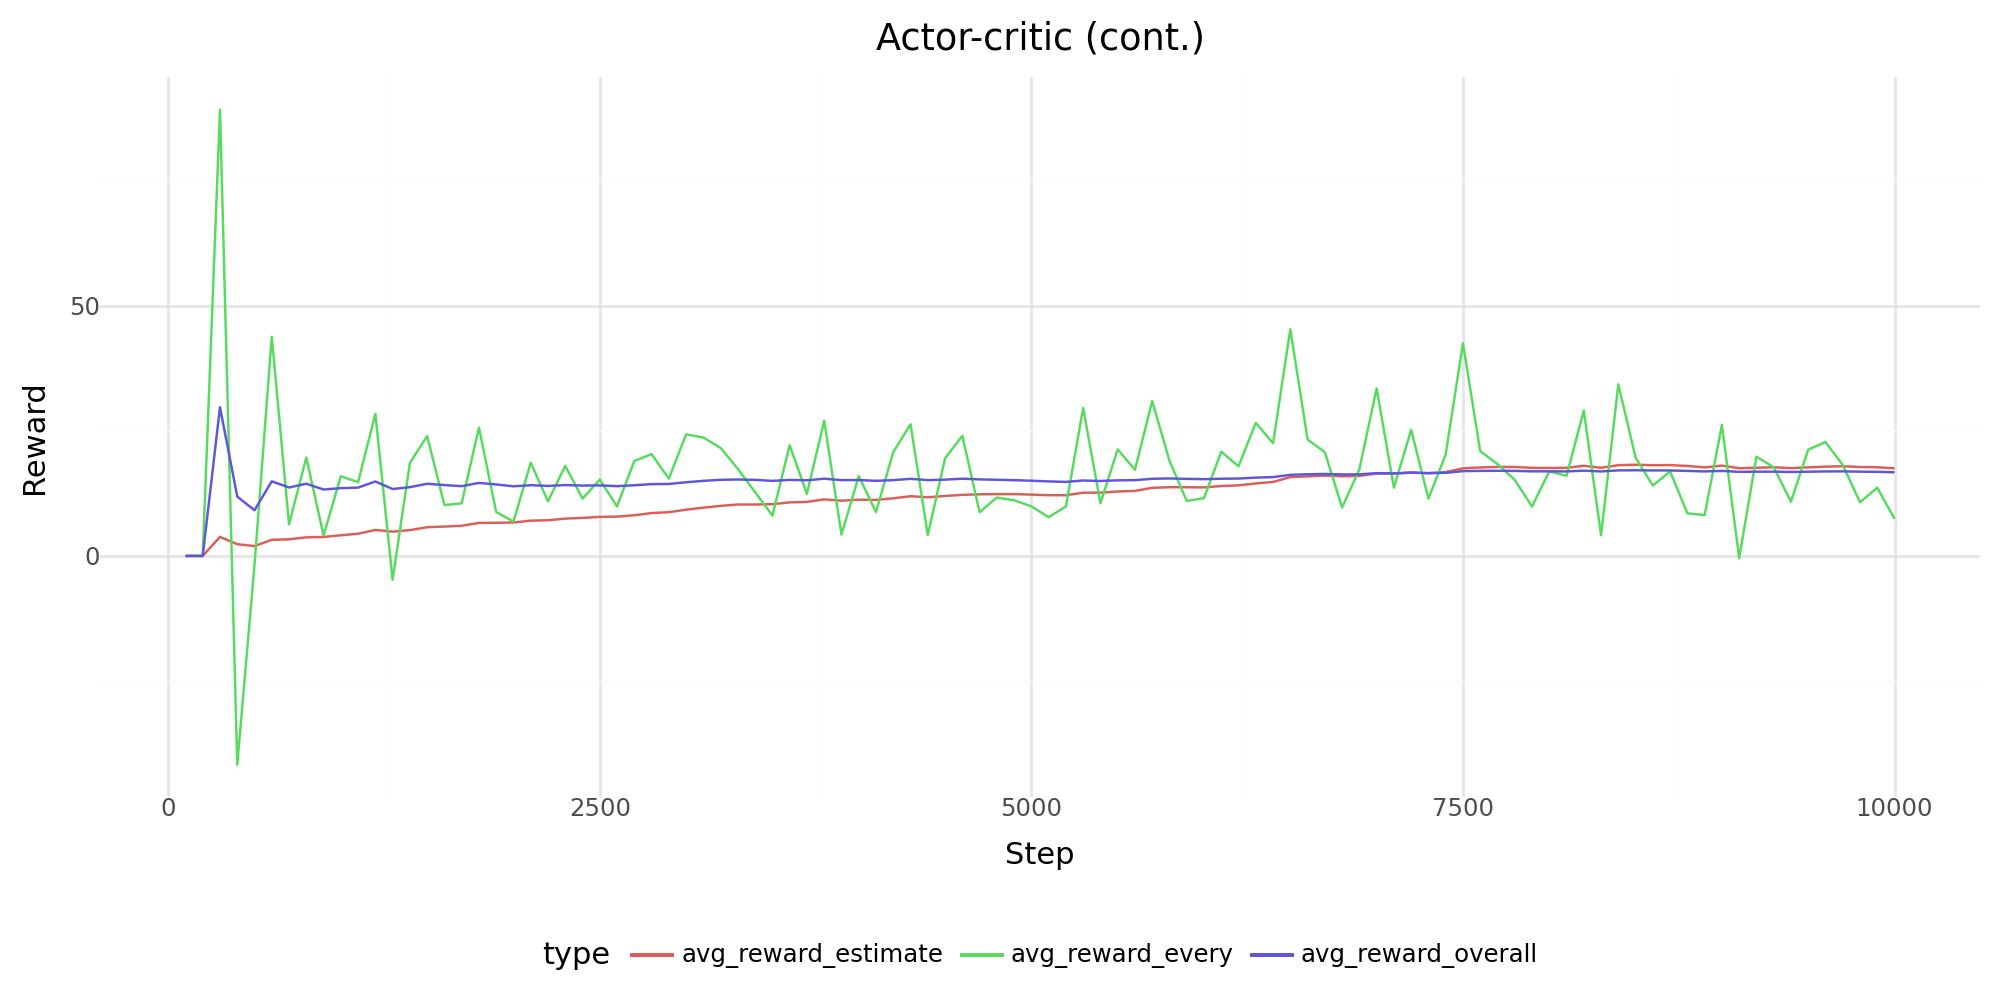

AttributeError: 'EnvEnergyCont' object has no attribute 'get_states'

In [12]:
from typing import Any, Optional
import numpy as np
import gdown
import gzip
import pandas as pd
import itertools
import joblib
import warnings
from dfply import *
from IPython.display import Markdown
from plotnine import *
from pprint import pprint
from scipy.stats import norm
from tqdm import tqdm

#@title TileCoder class (use as is)

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_rect, geom_text, geom_vline,
    scale_y_reverse, labs, theme_bw, theme
)
import hashlib
from typing import Iterable, Sequence, Tuple, Union


class TileCoder:
    """
    A practical TileCoder for RL (1D and ND).

    - Deterministic, evenly spaced offsets by default
    - Optional randomness via seed
    - Returns sparse active indices
    - Supports wrapping (per-dimension or global)
    - Exposes 1D attributes so existing plotting utilities work
    """

    def __init__(
        self,
        n_tilings: int,
        tiles_per_dim: Union[int, Sequence[int]],
        ranges: Union[None, Sequence[Tuple[float, float]]] = None,
        wrap: Union[bool, Sequence[bool]] = False,
        seed: Union[None, int] = None,
        deterministic: bool = True,
        hash_size: Union[None, int] = None,
    ):
        """
        A practical TileCoder for RL (1D and ND).

        Args:
            n_tilings (int): Number of tilings.
            tiles_per_dim (Union[int, Sequence[int]]): Tiles per dimension.
            ranges (Union[None, Sequence[Tuple[float, float]]], optional): Ranges for normalization to [0,1]. Defaults to None
            wrap (Union[bool, Sequence[bool]], optional): Wrap flags per dimension. Defaults to False
            seed (Union[None, int], optional): Random seed. Defaults to None
            deterministic (bool, optional): Use deterministic offsets. Defaults to True
            hash_size (Union[None, int], optional): Hash size for sparse encoding. Defaults to None
        """
        assert n_tilings >= 1
        self.n_tilings = int(n_tilings)

        if isinstance(tiles_per_dim, Iterable) and not isinstance(tiles_per_dim, (str, bytes)):
            self.tiles_per_dim = np.array(list(tiles_per_dim), dtype=int)
        else:
            self.tiles_per_dim = np.array([int(tiles_per_dim)], dtype=int)
        assert np.all(self.tiles_per_dim >= 2)

        self.d = int(self.tiles_per_dim.size)

        # Ranges for normalization to [0,1]
        if ranges is None:
            self.ranges = np.array([(0.0, 1.0)] * self.d, dtype=float)
        else:
            assert len(ranges) == self.d
            self.ranges = np.array(ranges, dtype=float)
            assert np.all(self.ranges[:, 1] > self.ranges[:, 0])

        # Wrap flags per dimension
        if isinstance(wrap, Iterable) and not isinstance(wrap, (str, bytes)):
            wrap = list(wrap)
            assert len(wrap) == self.d
            self.wrap = np.array(wrap, dtype=bool)
        else:
            self.wrap = np.array([bool(wrap)] * self.d, dtype=bool)

        self.hash_size = None if hash_size is None else int(hash_size)
        self.deterministic = bool(deterministic)
        self.seed = seed

        # Precompute strides for mixed-radix indexing
        self.tiles_strides = np.ones(self.d, dtype=int)
        for i in range(self.d - 2, -1, -1):
            self.tiles_strides[i] = self.tiles_strides[i + 1] * self.tiles_per_dim[i + 1]
        self.tiles_per_tiling = int(np.prod(self.tiles_per_dim))  # for 1D this equals tiles_per_dim

        # Offsets per tiling and dimension, as fractions of the unit interval
        self.offsets = self._make_offsets()

        # Expose attributes used by the existing 1D plotting helpers
        if self.d == 1:
            self.tiles_per_tiling_1d = int(self.tiles_per_dim[0])
            self.offsets_1d = self.offsets[:, 0]
            # Back-compat attribute names expected by the plotting code
            self.tiles_per_tiling = self.tiles_per_tiling_1d
            # plot helpers look for 'offsets' as 1D array; keep original 2D in _offsets2d
            self._offsets2d = self.offsets
            self.offsets = self.offsets_1d

    @property
    def n_features(self) -> int:
        if self.hash_size is not None:
            return self.hash_size
        return int(self.n_tilings * np.prod(self.tiles_per_dim))

    # ------------------------
    # Offset generation
    # ------------------------
    def _make_offsets(self) -> np.ndarray:
        """Create an (n_tilings, d) array of offsets in [0, 1/tiles_i)."""
        widths = 1.0 / self.tiles_per_dim.astype(float)
        if self.deterministic:
            # Evenly spaced along each dimension by fraction t/n_tilings of a bin width
            t = np.arange(self.n_tilings, dtype=float).reshape(-1, 1)
            base = (t / self.n_tilings)  # shape (n_tilings, 1)
            return (base * widths)  # broadcast to (n_tilings, d)
        else:
            rng = np.random.default_rng(self.seed)
            return rng.uniform(0.0, widths, size=(self.n_tilings, self.d))

    # ------------------------
    # Public API
    # ------------------------
    def active_indices(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Return the global feature indices (length n_tilings) for input x.
        x can be a scalar (1D) or a sequence of length d.
        """
        u = self._normalize_to_unit(x)  # in [0,1]^d
        inds = np.empty(self.n_tilings, dtype=np.int64)
        for t in range(self.n_tilings):
            idxs = self._tile_indices_for_tiling(u, t)
            if self.hash_size is None:
                inds[t] = t * self.tiles_per_tiling + self._linearize_indices(idxs)
            else:
                inds[t] = self._hash_index(t, idxs)
        return inds

    def encode_sparse(self, x: Union[float, Sequence[float]]):
        """Return (indices, values) for sparse features with value 1.0 for each tiling."""
        inds = self.active_indices(x)
        vals = np.ones_like(inds, dtype=float)
        return inds, vals

    def encode_dense(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Dense binary feature vector (mostly for debugging)."""
        size = self.n_features
        vec = np.zeros(size, dtype=float)
        inds = self.active_indices(x)
        vec[inds] = 1.0
        return vec

    # ------------------------
    # Internals
    # ------------------------
    def _normalize_to_unit(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        x = np.array([x], dtype=float) if np.isscalar(x) else np.array(x, dtype=float)
        assert x.size == self.d, f"Expected input of dimension {self.d}, got {x.size}"
        lo = self.ranges[:, 0]
        hi = self.ranges[:, 1]
        u = (x - lo) / (hi - lo)
        # Clamp to [0,1] to avoid numerical overflow in min/floor
        return np.clip(u, 0.0, 1.0)

    def _tile_indices_for_tiling(self, u: np.ndarray, t: int) -> np.ndarray:
        offs = self.offsets[t]
        v = u + offs
        idxs = np.empty(self.d, dtype=int)
        for i in range(self.d):
            if self.wrap[i]:
                w = v[i] % 1.0
            else:
                w = min(v[i], 1.0 - 1e-12)
            idxs[i] = int(np.floor(w * self.tiles_per_dim[i]))
        return idxs

    def _linearize_indices(self, idxs: np.ndarray) -> int:
        return int(np.dot(idxs, self.tiles_strides))

    def _hash_index(self, t: int, idxs: np.ndarray) -> int:
        # Deterministic hash of (t, idxs...)
        payload = np.array([t, *idxs.tolist()], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % int(self.hash_size)

    # ------------------------
    # 1D plotting helpers as methods (plotnine)
    # ------------------------
    def _assert_1d(self):
        assert self.d == 1, "plot_1d is only available for 1D tile coders"

    def _wrap_flag_1d(self) -> bool:
        return bool(self.wrap[0])

    def _bin_bounds_for_tiling_1d(self, offset: float) -> list:
        """Compute (start,end) intervals for bins in one tiling.
        Honors wrap setting; non-wrap lets the last tile extend to 1.0.
        """
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        width = 1.0 / T
        if wrap:
            starts = (np.arange(T) * width - offset) % 1.0
            ends = (starts + width) % 1.0
            return list(zip(starts, ends))
        else:
            out = []
            for b in range(T):
                if b < T - 1:
                    s = b * width - offset
                    e = (b + 1) * width - offset
                else:
                    s = (T - 1) * width - offset
                    e = 1.0
                s = max(0.0, s)
                e = min(1.0, e)
                out.append((s, e))
            return out

    def _active_tile_for_tiling_1d(self, z: float, offset: float) -> int:
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        val = (z + offset) % 1.0 if wrap else min(z + offset, 1.0 - 1e-12)
        return int(np.floor(val * T))

    def build_tile_df_1d(self, z: float = 0.37) -> pd.DataFrame:
        self._assert_1d()
        wrap = self._wrap_flag_1d()
        recs = []
        for t in range(self.n_tilings):
            bins = self._bin_bounds_for_tiling_1d(self.offsets[t])
            active_tile = self._active_tile_for_tiling_1d(z, self.offsets[t])
            for b, (s, e) in enumerate(bins):
                is_active = (b == active_tile)
                if wrap and s > e:
                    recs.append(dict(
                        tiling=t, tile=b, xmin=0.0, xmax=e, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(0.0 + e) / 2.0, ycenter=t, active=is_active
                    ))
                    recs.append(dict(
                        tiling=t, tile=b, xmin=s, xmax=1.0, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(s + 1.0) / 2.0, ycenter=t, active=is_active
                    ))
                    continue
                if e <= s:
                    continue
                recs.append(dict(
                    tiling=t, tile=b, xmin=s, xmax=e, ymin=t-0.45, ymax=t+0.45,
                    xcenter=(s + e) / 2.0, ycenter=t, active=is_active
                ))
        return pd.DataFrame(recs)

    def plot_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Return a plotnine ggplot object visualizing 1D tiles and active bin per tiling."""
        self._assert_1d()
        df = self.build_tile_df_1d(z)
        ttl = title if title else f"TileCoder (wrap={'True' if self._wrap_flag_1d() else 'False'})"
        p = (
            ggplot(df, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='active'))
            + geom_rect(alpha=0.35, color='black', size=0.2)
            + geom_text(aes(x='xcenter', y='ycenter', label='tile'), size=6)
            + geom_vline(xintercept=z, linetype='dashed')
            + scale_y_reverse()
            + labs(title=f"{ttl} — z={z:.2f}", x='z in [0,1]', y='Tiling index')
            + theme_bw()
            + theme(figure_size=(10, 2))
        )
        return p

    def show_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Convenience: build and immediately render the 1D plot (if in an environment that supports .show())."""
        return self.plot_1d(z, title).show()



class EnvEnergyCont:
    """
    Environment for the hour-to-hour electricity market problem with continuous actions.
    """

    def __init__(self, settings, seed = 25328):
        """
        Initialize the environment.

        Args:
            settings (dict): A dictionary containing problem settings
            seed (int): A seed for the random number generator
        """
        self.settings = settings

        ## price model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1cGhte06iiWZnaRLPyj5D8ZzWX7gqPsIR'
        # Output filename for the downloaded file
        output_filename = 'prices_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_price = joblib.load(f)
        print(f"Price model loaded successfully from {output_filename}")
        self.model_price = model_price

        ## wind model
        # Google Drive direct download URL (using the 'uc?id=' format)
        url = 'https://drive.google.com/uc?id=1TJ1ACzev40QbeUlXBbDicYU3kEyiH1nB'
        # Output filename for the downloaded file
        output_filename = 'wind_log_ar1.pkl.gz'
        # Download the file from Google Drive
        gdown.download(url, output_filename, quiet=True)
        # Load the model from the downloaded file
        with gzip.open(output_filename, "rb") as f:
            model_wind = joblib.load(f)
        print(f"Wind model loaded successfully from {output_filename}")
        self.model_wind = model_wind

        self.rng = np.random.default_rng(seed)

    def reset_rng(self, seed):
        """
        Reset the random number generator.

        Args:
            seed (int): A seed for the random number generator
        """
        self.rng = np.random.default_rng(seed)

    def reset(self, seed: Optional[int] = None, initial_state: Optional[tuple] = None):
        """
        Reset environment RNG (optional) and return an initial valid state.

        Args:
            seed (Optional[int]): If provided, reset internal RNG to this seed.
            initial_state (Optional[tuple]): If provided, use this state after
                validating it with `check_s` (must be [s_l, s_c, s_w, s_p]).

        Returns:
            list: Initial state `[s_l, s_c, s_w, s_p]` for the environment.
        """
        if seed is not None:
            self.reset_rng(seed)

        if initial_state is not None:
            # validate and return provided state
            self.check_s(initial_state)
            return list(initial_state)

        # Create a reasonable default initial state
        b_max = float(self.settings.get('b_max', 1.0))
        c_max = float(self.settings.get('c_max', 1.0))

        # Start with empty battery and zero commitment
        s_l = 0.0
        s_c = 0.0

        # Sample an initial positive wind speed (avoid zero to keep log-stable)
        # Use a small positive base then one-step generate to respect AR(1)
        base_w = 1.0
        try:
            s_w = float(self.generate_wind_next_hour(base_w))
        except Exception:
            s_w = float(self.settings.get('w_rated', 1.0) / 2.0)

        # Sample an initial price from the price model using a base price 0
        try:
            s_p = float(self.generate_price_next_hour(0.0))
        except Exception:
            s_p = 0.0

        s = [s_l, s_c, s_w, s_p]
        # ensure state is valid
        self.check_s(s)
        return s

    def check_s(self, s):
        """
        Check if a state is valid.
        """
        s_l, s_c, s_w, _ = s
        assert s_l >= 0 and s_l <= self.settings['b_max']
        assert s_c >= -self.settings['b_max'] and s_c <= self.settings['c_max']
        assert s_w >= 0

    def check_a(self, a):
        """
        Check if an action is valid.
        """
        a_b, a_w, a_c = a
        b_max = self.settings['b_max']
        c_max = self.settings['c_max']
        if not (a_b >= -b_max and a_b <= b_max):
            raise ValueError(f"Invalid a_b={a_b} outside [-{b_max},{b_max}]")
        if not (a_w >= 0):
            raise ValueError(f"Invalid a_w={a_w} (must be >= 0)")
        if not (a_c >= -b_max and a_c <= c_max):
            raise ValueError(f"Invalid a_c={a_c} outside [-{b_max},{c_max}]")

    def get_action_info(self, s: tuple) -> tuple:
        """
        Get fixed actions for a given state and the minimum a_c value to choose.
        """
        self.check_s(s)
        s_l, s_c, s_w, _ = s
        b_max = self.settings['b_max']
        # Determine a_b and a_w
        e_max = self.energy(s_w) # max wind energy we can sell/produce
        if s_c >= 0:
            if s_c >= e_max:
                a_b = min(s_l, s_c - e_max)
                a_w = e_max
            else: # s_c < e_max:
                a_b = -min(b_max - s_l, e_max - s_c)
                a_w = s_c - a_b
        else: # s_c < 0:
            a_b = -min(b_max - s_l, - s_c + e_max)
            a_w = max(0, - a_b + s_c)
        # print(f"s_c: {s_c},  s_w: {s_w}, e_max: {e_max}")
        # print(f"s_l: {s_l}, a_b: {a_b}, a_w: {a_w}, min a_c: {-(b_max - (s_l - a_b))}")
        a_c_min = -(b_max - (s_l - a_b))  # no need to buy power that cannot be stored
        return float(a_b), float(a_w), float(a_c_min)

    def state_variables_to_str(self, s_l, s_c, s_w, s_p):
        """
        String representaion of a state.
        """
        return "{'s_l': " + str(s_l) + ", 's_c': " + str(s_c) + ", 's_w': " + str(s_w) + ", 's_p': " + str(s_p) + "}"

    def action_variables_to_str(self, a_b, a_w, a_c):
        """
        String representaion of an action.
        """
        return "{'a_b': " + str(a_b) + ", 'a_w': " + str(a_w) + ", 'a_c': " + str(a_c) + "}"

    def power(self, wind_speed):
        """
        The power output of a wind turbine given a wind speed.
        """
        p_max = self.settings['p_max']
        w_cut_in = self.settings['w_cut_in']
        w_rated = self.settings['w_rated']
        w_cut_out = self.settings['w_cut_out']

        if wind_speed < w_cut_in:
            return 0
        elif w_cut_in <= wind_speed <= w_rated:
            return p_max * ((wind_speed - w_cut_in) / (w_rated - w_cut_in)) ** 3
        elif w_rated < wind_speed <= w_cut_out:
            return p_max
        else:
            return 0

    def energy(self, w, time_period_length = 1):
        """
        The energy output of a wind turbine over one hour given a wind speed (MWh).
        """
        return self.power(w) * time_period_length

    def get_reward(self, s_p, s_c, a_b, a_w):
        """
        Calculate the reward for given state-action values.
        """
        c_plus = self.settings['c_plus']
        c_minus = self.settings['c_minus']
        e = a_b + a_w
        if s_p >= 0:
            return s_c * s_p - c_plus * abs(s_c - e)
        if s_p < 0:
            return s_c * s_p - c_minus * abs(s_c - e)
        raise ValueError("Reward can not be calculated.")

    def generate_price_next_hour(self, price):
        """
        Generates a random sample of the price for the next hour based on an AR(1) model.

        Args:
            price (float): The current price.

        Returns:
            float: A random sample of the next hour's price.
        """
        phi = self.model_price.params.iloc[1]
        intercept = self.model_price.params.iloc[0]
        sigma = self.model_price.resid.std()
        # The mean of the next price's distribution is the predicted value
        mean_next_price = intercept + phi * price
        # The standard deviation of the next price's distribution is the residual standard deviation
        std_dev_next_price = sigma
        # Generate a random sample from a normal distribution and clip to
        # a reasonable range to avoid numerical explosions during training.
        price_next_sample = self.rng.normal(loc=mean_next_price, scale=std_dev_next_price)
        # Clip price to a large but finite window
        price_next_sample = float(np.clip(price_next_sample, -1e6, 1e6))
        return price_next_sample

    def generate_wind_next_hour(self, wind):
        """
        Generates a random sample of the wind speed for the next hour based on an AR(1) model.

        Args:
            wind (float): The current wind speed.

        Returns:
            float: A random sample of the next hour's wind speed.
        """
        # Add a small epsilon to prevent log(0) if wind is zero.
        # This ensures numerical stability for the log-transformed AR(1) model.
        min_positive_wind = 1e-6 # A very small positive number to avoid log(0)
        log_wind = np.log(max(wind, min_positive_wind))
        phi = self.model_wind.params.iloc[1]
        intercept = self.model_wind.params.iloc[0]
        sigma = self.model_wind.resid.std()
        # The mean of the next wind speed's distribution is the predicted value
        log_mean_next_wind = intercept + phi * log_wind
        # The standard deviation of the next wind speed's distribution is the residual standard deviation
        std_dev_next_wind = sigma
        # Generate a random sample from a normal distribution
        log_wind_next_sample = self.rng.normal(loc=log_mean_next_wind, scale=std_dev_next_wind)
        # Clamp the log value to avoid producing extremely large winds
        max_w_bound = max(self.settings.get('w_cut_out', 25) * 2.0, 50.0)
        max_log = np.log(max_w_bound)
        min_log = np.log(1e-6)
        log_wind_next_sample = float(np.clip(log_wind_next_sample, min_log, max_log))
        return float(np.exp(log_wind_next_sample))

    def get_step(self, s: tuple, a: tuple):
        """
        Compute one-step transition and reward from (s, a).

        Args:
            s: State label
            a: Action label

        Returns:
            tuple: (sN, r)
        """
        self.check_s(s)
        self.check_a(a)
        s_l, s_c, s_w, s_p = s
        a_b, a_w, a_c = a
        s_l_next = float(s_l - a_b)
        s_c_next = float(a_c)
        s_w_next = float(self.generate_wind_next_hour(s_w)) # update current values
        s_p_next = float(self.generate_price_next_hour(s_p))
        s_next = [s_l_next, s_c_next, s_w_next, s_p_next]
        self.check_s(s_next)
        reward = float(self.get_reward(s_p, s_c, a_b, a_w))
        return s_next, reward



def generate_discrete_set(min_val, max_val, step):
    """
    Generates a set of discrete values from min_val to max_val with step size.

    Args:
        min_val (float): The minimum value in the set.
        max_val (float): The maximum value in the set.
        step (float): The step size between consecutive values.

    Returns:
        set: A set of discrete values {min_val,…,−𝛿,0,𝛿,...,max_val}.
    """
    # Ensure step is a divisor of min_val
    if not np.isclose(min_val % step, 0):
        raise ValueError("min_val argument must be divisible by step.")
    if not np.isclose(max_val % step, 0):
        raise ValueError("max_val argument must be divisible by step.")
    return np.arange(min_val, max_val + step, step)

# These settings could be changed (not in original code)
settings = {
    'b_max': 10,  # battery capacity (MWh)
    'p_max': 10,  # max power output wind (MW)
    'c_max': 10 + 10,  # max commitment (MWh) # b_max + p_max
    'w_cut_in': 3,  # cut in wind speed (m/s)
    'w_rated': 12,  # rated wind speed (m/s)
    'w_cut_out': 25,  # cut out wind speed (m/s)
    'c_plus': 50,  # EUR/MWh
    'c_minus': 50, # EUR/MWh
}



import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicy:
    """Continuous actor for `EnvEnergyCont` that picks the controllable
    commitment `a_c` according to a Gaussian policy. The battery and wind
    components `(a_b, a_w)` are obtained deterministically from
    `env.get_action_info(s)`.

    The policy parameterises the mean of `a_c` as a linear function of
    state-features x(s) = [1, s_l / b_max, s_c / c_max, s_w / p_max, s_p / p_norm]
    with a parameter vector `theta`. A fixed standard deviation `sigma`
    is used for sampling; the log-gradient for a single sample with
    fixed sigma is (a_c - mu)/sigma^2 * x(s).
    """

    def __init__(
        self,
        env: object,
        step_size: float,
        sigma: float = 1.0,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
    ) -> None:
        self.env = env
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)
        self.sigma = float(sigma)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Feature construction uses environment settings where available
        s = env.settings
        self.b_max = float(s.get("b_max", 1.0))
        self.c_max = float(s.get("c_max", 1.0))
        self.p_max = float(s.get("p_max", 1.0))
        # Price normaliser: fallback to 1.0 if not provided
        self.p_norm = float(max(abs(s.get("p_norm", 1.0)), 1.0))

        # Number of features: bias + 4 state normalised entries
        self.num_features = 5

        # Parameter vector for mean(a_c | s)
        self.theta = np.zeros(self.num_features, dtype=float)

    def reset(self) -> None:
        """Reset parameters and RNG to initial values."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    def get_state_features(self, s) -> np.ndarray:
        """Build feature vector from EnvEnergyCont state `s = [s_l,s_c,s_w,s_p]`.

        Returns: numpy array shape (num_features,)
        """
        s_l, s_c, s_w, s_p = s
        # Normalise by known maxima to keep features well-scaled and
        # clamp to safe ranges to prevent numerical instability.
        s_l_n = float(s_l) / max(self.b_max, 1e-6)
        s_c_n = float(s_c) / max(self.c_max, 1e-6)
        s_w_n = float(s_w) / max(self.p_max, 1e-6)
        s_p_n = float(s_p) / max(self.p_norm, 1e-6)

        # Clip sensible ranges
        s_l_n = float(np.clip(s_l_n, 0.0, 1.0))
        s_c_n = float(np.clip(s_c_n, -1.0, 1.0))
        s_w_n = float(np.clip(s_w_n, 0.0, max(2.0, s_w_n)))
        s_p_n = float(np.clip(s_p_n, -1e3, 1e3))

        arr = np.asarray([1.0, s_l_n, s_c_n, s_w_n, s_p_n], dtype=float)
        # Replace any non-finite values with zeros
        arr = np.where(np.isfinite(arr), arr, 0.0)
        return arr

    def get_mean(self, s) -> float:
        x = self.get_state_features(s)
        mu = float(np.dot(self.theta, x))
        if not np.isfinite(mu):
            # fallback to zero mean if numerical issues occur
            return 0.0
        return mu

    def get_action(self, s):
        """Return a full action tuple (a_b, a_w, a_c).

        a_b and a_w are taken from `env.get_action_info(s)` while a_c is
        sampled from N(mu(s), sigma^2) and clipped to feasible range.
        """
        a_b, a_w, a_c_min = self.env.get_action_info(s)
        mu = self.get_mean(s)
        if not np.isfinite(mu):
            mu = 0.0
        # Bounds for a_c
        a_c_low = float(a_c_min)
        a_c_high = float(self.env.settings.get("c_max", a_c_low))

        # Sample and clip
        a_c = float(self.rng.normal(loc=mu, scale=self.sigma))
        if not np.isfinite(a_c):
            a_c = float(np.clip(mu, a_c_low, a_c_high))
        a_c = float(np.clip(a_c, a_c_low, a_c_high))
        return (a_b, a_w, a_c)

    def get_best_action(self, s):
        """Return deterministic action using mean for a_c."""
        a_b, a_w, a_c_min = self.env.get_action_info(s)
        mu = self.get_mean(s)
        a_c = float(np.clip(mu, a_c_min, self.env.settings.get("c_max", mu)))
        return (a_b, a_w, a_c)

    def get_log_gradient(self, s, a) -> np.ndarray:
        """Return gradient ∇_theta log π(a | s).

        `a` is the full action tuple (a_b,a_w,a_c); gradient only applies to
        the parameters controlling the mean of `a_c`.
        """
        # Extract a_c
        if isinstance(a, (list, tuple)):
            a_c = float(a[2])
        else:
            a_c = float(a)

        x = self.get_state_features(s)
        # guard against non-finite features
        if not np.all(np.isfinite(x)):
            x = np.zeros_like(x)
        mu = self.get_mean(s)
        # Gradient for Gaussian with fixed sigma
        grad = ((a_c - mu) / (self.sigma ** 2)) * x
        # ensure finite gradient
        grad = np.where(np.isfinite(grad), grad, 0.0)
        return grad

    def train(self, s, a, mult: float) -> None:
        """Apply policy gradient update: theta <- theta + alpha * mult * grad.

        `mult` is the scalar advantage (e.g. δ_t) passed from the actor-critic.
        """
        grad = self.get_log_gradient(s, a)
        if not np.all(np.isfinite(grad)):
            return
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct

# Plot trace
def plot_results_cont(pi_hat, trace, title_r = "", print_dist = False, plot_policy = True):
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "reward" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("step", "r", color = "type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Step",
            y="Reward",
        )
    )
    pt.show()

    if plot_policy:
        dat_a = pd.DataFrame({'s': pi_hat.env.get_states()})
        dat_a = (
            dat_a
            >> mutate(
                x = X.s.apply(lambda s: s[0]),
                y = X.s.apply(lambda s: s[1]),
                action = [pi_hat.get_best_action(s) for s in dat_a['s']],
                alg = title_r
            )
            >> select(~X.s)
        )
        dat_a['action'] = pd.Categorical(dat_a['action'])
        pt = (
            ggplot(dat_a, aes(x = "x", y = "y", color = "action", label="action", size="action"))
            + geom_label(size = 6)
            + theme(figure_size=(10, 5), legend_position='bottom')
            + labs(title = "Actions")
        )
        pt.show()


    # visited states
    dat_s = [ [s[0], s[1], env.s_ctr[env.st2idx[s]]] for s in env.get_states()]
    dat_s = pd.DataFrame(dat_s, columns=['x', 'y', 'n'])
    dat_s = dat_s >> mask(X.n > 0)
    pt = (
        ggplot(dat_s, aes(x = 'x', y = 'y', size = 'n'))
        + geom_point(alpha = 0.5)
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(title = "Visited states")
    )
    pt.show()

    if print_dist:
        # print(f"Theta: {pi_hat.theta}")
        print("A few probability distributions:")
        test_states = [(10, 10),(1, 1), (1, 20), (20, 1)]
        for s in test_states:
            actions = pi_hat.env.get_actions(s)
            prefs = pi_hat.get_action_preferences(s)
            probs = pi_hat.get_action_probs(s)
            print(f"State {s}:")
            for a, p, pf in zip(actions, probs[1], prefs):
                print(f"  a={a:5.1f}, π(a|s)={p:6.3f} h(s,a)={pf:6.3f}")
            print()


from typing import Any
def actor_critic_continuing(
    pi_hat,
    v_hat,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    callback = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """
    Differential (average-reward) one-step actor–critic for continuing tasks.

    This version assumes a continuing task with no terminal states, and uses
    the average-reward formulation:

        δ_t = R_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t)

    Critic (TD(0)):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate:
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with value(s) and train(s, target).
               train(s, target) should move v_hat(s) toward `target`.
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄.
        callback: Optional logging callback.
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback.
    """

    # Initialize
    s = pi_hat.env.reset()
    r_bar = r_bar_ini

    total_reward = 0.0
    total_reward_every = 0.0

    for t in tqdm(range(1, steps + 1)):
        # Sample action from current policy
        a = pi_hat.get_action(s)

        # Environment step (continuing task: no 'done' flag)
        s_next, r = pi_hat.env.get_step(s, a)

        # Critic: TD error for differential value
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta_t = r - r_bar + v_s_next - v_s

        # Actor: update with δ_t
        mult = delta_t
        pi_hat.train(s, a, mult)

        # Critic: semi-gradient TD(0) toward v_s + δ_t
        td_target = v_s + delta_t
        v_hat.train(s, td_target)

        # Average reward update
        r_bar += alpha_r * delta_t

        # Bookkeeping
        total_reward += r
        total_reward_every += r

        # Optional logging callback (in terms of steps, not episodes)
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            info = {
                "step": t,
                "avg_reward_estimate": r_bar,
                "avg_reward_overall": total_reward / t,
                "avg_reward_every": total_reward_every / callback_every,
            }
            total_reward_every = 0.0
            callback(pi_hat, info, trace)

        # Move to next state
        s = s_next
    print("Final average reward estimate:", round(r_bar,2))


#@title Tile coding value function


# -------------------------------------------------------------
# You must ensure the TileCoder class (your long definition above)
# is available in your environment.
# -------------------------------------------------------------


class ValueFunctionTileCoding:
    """
    Linear value function approximator with internally constructed TileCoder.

        v(s) = w^T x(s)

    x(s) is sparse tile-coded features created by a TileCoder built
    *inside* this class.
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        n_tilings: int,
        tiles_per_dim,
        init_val: float = 0.0,
        deterministic: bool = True,
        seed: Optional[int] = None,
    ):
        """
        Args:
            env: The environment.
            step_size: Learning rate α_v (divided internally by n_tilings).
            n_tilings: Number of tilings for tile coding.
            tiles_per_dim: Int or list of ints for each dimension.
            ranges: List of (min, max) for each dimension.
            wrap: Whether to wrap each dimension.
            init_val: Initial approximate V(s).
            deterministic: Deterministic or random offsets.
            seed: Optional seed.
            hash_size: Optional hashing size for tile coding.
        """
        self.env = env

        # --- Construct TileCoder internally ---
        # For EnvEnergyCont use the battery level `s_l` and commitment `s_c`
        # as the two dimensions for the tile coder. Ranges are taken from
        # the environment settings to keep features well scaled.
        b_max = float(env.settings.get('b_max', 1.0))
        c_max = float(env.settings.get('c_max', 1.0))
        s_l_range = (0.0, b_max)
        # s_c can be negative (short position) so range spans [-b_max, c_max]
        s_c_range = (-b_max, c_max)

        self.tc = TileCoder(
            n_tilings=n_tilings,
            tiles_per_dim=tiles_per_dim,
            ranges=[s_l_range, s_c_range],
            wrap=False,
            seed=seed,
            deterministic=deterministic,
        )

        # --- learning rate ---
        # Good practice: divide by number of tilings so V-learning is stable
        self.alpha = float(step_size) / n_tilings

        # --- parameters ---
        self.n_features = self.tc.n_features

        # Initialize weights so v(s) ≈ init_val
        w0 = init_val / n_tilings
        self.w = np.full(self.n_features, w0, dtype=float)

    # ------------------------------------------------------------------

    def _features(self, s):
        """Sparse tile-coded features (idxs, vals)."""
        # EnvEnergyCont state is [s_l, s_c, s_w, s_p]; TileCoder was
        # constructed over (s_l, s_c) only, so pass those two components.
        arr = np.asarray([float(s[0]), float(s[1])], dtype=float)
        return self.tc.encode_sparse(arr)

    # ------------------------------------------------------------------

    def eval(self, s) -> float:
        """Return v(s)."""
        idxs, vals = self._features(s)
        return float(np.dot(self.w[idxs], vals))

    # ------------------------------------------------------------------

    def train(self, s, target: float) -> None:
        """
        Semi-gradient TD update toward target:

            δ = target - v(s)
            w <- w + α * δ * x(s)
        """
        idxs, vals = self._features(s)
        v_s = np.dot(self.w[idxs], vals)
        delta = target - v_s
        self.w[idxs] += self.alpha * delta * vals


#@title Softmax monotone policy

import numpy as np
from typing import Any, Dict, Hashable, List, Optional, Tuple


class SoftmaxPolicyMonotoneXY:
    """
    Softmax policy with *monotone* action structure over 2D state (x, y).

    State s = (x, y), with integer x,y (e.g. 0..20).

    We define a scalar "pressure" function:

        g(x, y) = b + exp(u1) * x - exp(u2) * y

    so that:
      - ∂g/∂x = exp(u1) >= 0  ⇒ g increases with x
      - ∂g/∂y = -exp(u2) <= 0 ⇒ g decreases with y

    Preferences (for numeric actions a):

        h(s, a) = a * g(x, y)

    Policy over feasible actions in state s:

        π(a | s) = exp(h(s,a)) / Σ_{a' feasible} exp(h(s,a'))

    As g(x,y) increases (higher x or lower y), probability mass shifts
    to larger actions a. As g(x,y) decreases (lower x or higher y),
    probability shifts to smaller actions a.

    This guarantees:
      1) For fixed x, as y increases, the distribution moves towards
         smaller actions (so the chosen action tends to decrease).
      2) For fixed y, as x increases, distribution moves towards larger
         actions (so the chosen action tends to increase).

    (Subject to feasibility constraints in env.get_actions(s).)
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Args:
            env: Environment with get_states() and get_actions(s).
                 Actions must be numeric and ordered (like -5..+5).
            step_size: Learning rate α_θ for policy updates.
            rng_seed: Optional seed for action sampling.
        """
        self.env = env
        self.alpha = float(step_size)
        self.rng = np.random.default_rng(rng_seed)

        # Parameters of g(x,y): b, u1, u2 (unconstrained).
        # We use exp(u1), exp(u2) to enforce correct signs.
        self.b = 0.0
        self.u1 = 0.0
        self.u2 = 0.0

    # ------------------------------------------------------------------

    def _g(self, s: Hashable) -> float:
        """Compute g(x,y) for state s = (x, y)."""
        x, y = s
        w1 = np.exp(self.u1)   # >= 0
        w2 = np.exp(self.u2)   # >= 0
        return self.b + w1 * x - w2 * y

    def _softmax(self, prefs: np.ndarray) -> np.ndarray:
        """Numerically stable softmax over 1D array."""
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    # ------------------------------------------------------------------

    def action_probs(self, s: Hashable) -> Tuple[List[Any], np.ndarray]:
        """
        Return feasible actions and their probabilities π(·|s).

        Args:
            s: State (x, y).

        Returns:
            (actions, probs)
        """
        g_val = self._g(s)

        # Feasible actions in this state (e.g. -5..+5, truncated)
        actions = list(self.env.get_actions(s))
        actions = sorted(actions)  # ensure numeric order

        # Preferences: h(s,a) = a * g(x,y)
        prefs = np.array([a * g_val for a in actions], dtype=float)

        probs = self._softmax(prefs)
        return actions, probs

    # ------------------------------------------------------------------

    def get_action(self, s: Hashable) -> Any:
        """
        Sample an action from π(·|s).

        Args:
            s: State (x,y).

        Returns:
            Sampled action.
        """
        actions, probs = self.action_probs(s)
        idx = self.rng.choice(len(actions), p=probs)
        return actions[idx]

    def get_best_action(self, s: Hashable) -> Any:
        """
        Return the best action in state s.
        """
        actions, probs = self.action_probs(s)
        return actions[np.argmax(probs)]

    # ------------------------------------------------------------------

    def train(self, s: Hashable, a: Any, mult: float) -> None:
        """
        Policy-gradient update with monotonicity preserved.

        Performs:
            θ ← θ + α * mult * ∇_θ log π(a|s)

        Here θ = (b, u1, u2), and

            h(s,a) = a * g(x,y)
            g(x,y) = b + e^{u1} x - e^{u2} y

        For softmax with h(s,a) = a g(s),

            ∂ log π(a|s) / ∂g = a - E_π[A | s]

        and

            ∂g / ∂b  = 1
            ∂g / ∂u1 = e^{u1} * x
            ∂g / ∂u2 = -e^{u2} * y

        So:

            ∇_θ log π(a|s) = (a - E[A|s]) * (∂g/∂b, ∂g/∂u1, ∂g/∂u2)

        The 'mult' is usually δ_t (or I_t * δ_t in episodic versions).
        """
        x, y = s
        g_val = self._g(s)

        # Feasible actions & probabilities
        actions = list(self.env.get_actions(s))
        actions = sorted(actions)
        prefs = np.array([a_j * g_val for a_j in actions], dtype=float)
        probs = self._softmax(prefs)

        # Expected action under current policy: E_π[A | s]
        actions_arr = np.array(actions, dtype=float)
        A_bar = float(np.dot(probs, actions_arr))

        # Check that chosen action is feasible
        if a not in actions:
            raise ValueError(f"Action {a} not feasible in state {s}")

        # Factor (a - E[A|s]) from ∂ log π / ∂g
        factor = float(a - A_bar)

        # Gradients of g
        w1 = np.exp(self.u1)
        w2 = np.exp(self.u2)
        dg_db = 1.0
        dg_du1 = w1 * x
        dg_du2 = -w2 * y

        # Full gradient of log π wrt (b, u1, u2)
        grad_b = factor * dg_db
        grad_u1 = factor * dg_du1
        grad_u2 = factor * dg_du2

        # Update
        self.b  += self.alpha * mult * grad_b
        self.u1 += self.alpha * mult * grad_u1
        self.u2 += self.alpha * mult * grad_u2



# --- environment ---
envC = EnvEnergyCont(settings)

# --- hyperparameters ---
alpha_theta = 1e-3   # actor step size
alpha_v     = 0.5    # critic step size (before /n_tilings adjustment)
alpha_r     = 3e-4   # average-reward step size
n_tilings   = 64
tiles_per_dim = [20, 20]
total_steps = 10000
callback_every = min(total_steps / 100, 500)

# --- actor: tabular softmax over state–action pairs ---
pi_hat = SoftmaxPolicy(
    env=envC,
    step_size=alpha_theta,
    sigma=1.0,
    rng_seed=878,
)

v_hat = ValueFunctionTileCoding(
    env=envC,
    step_size=alpha_v,
    n_tilings=n_tilings,
    tiles_per_dim=tiles_per_dim,
    init_val=0.0,
    seed=249
)
def callback(pi_hat, info, trace):
    trace.append(info)

# --- run ---
trace = []
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=total_steps,
    alpha_r=alpha_r,
    callback=callback,
    callback_every=callback_every,
    trace=trace,
)

plot_results_cont(pi_hat, trace, title_r = "Actor-critic (cont.)")